In [1]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Patch

import pandas as pd
import seaborn as sns

# Turn off logging for NUTS sampler for PyMCMC
import logging

logger = logging.getLogger("pymc")
logger.setLevel(logging.ERROR)

![laserbayes](./bayes.jpg)

# Bayesian Models

It is now time to explore the "other side" of the most significant ideological debate in applied statistics—Bayesian vs Frequentist statistics. Until now you did not have the terminology and concepts to really understand what is going on here, but now you do.

To start out, let's just say that there is no "right" way to do inferential statistics. Whichever approach you like better can be used in professional or academic data analysis, and **you should be able to read research that uses either approach**.


### `bambi`

We will install some new software. The [Bambi](https://bambinos.github.io/bambi/) project uses R-style formula language (this is what you have been learning) on top of some other tools to present a fairly intuitive environment. `statsmodels` can do most of the same models, but for many of them it becomes much, *much* harder to understand, and the documentation is written for 'real' statisticians, which makes it challenging.

**We really, really, really, (really) recommend installing `bambi` with some kind of conda environment**. Most importantly this should ensure that you get the best versions of BLAS (a hardware accelerated linear algebra library) for your hardware and operating system. This should look something like:

 `conda install -c conda-forge bambi`

In [2]:
import arviz as az
import bambi as bmb
import xarray as xr  # to see the version

In [3]:
rng = np.random.default_rng(seed=42)

# "...Yet again???"

Instead of explaining everything, we will dive right in, by returning to the first linear regression that we did—the Arthurian Manuscripts.


In [4]:
df = pd.read_csv("../../datasets/arthur/manuscripts.csv", index_col=0)
df.columns = df.columns.str.replace("-", "_")

page_cols = ["leaf_height", "leaf_width", "text_height", "text_width"]
mss = df[
    page_cols
    + [
        "script",
        "material",
        "physical_type",
    ]
].dropna()
mss = mss[mss.script.isin(["textualis", "cursive"])]

# Divide by 10 for mm -> cm
mss[page_cols] = mss[page_cols].apply(lambda x: x / 10)

mss["text_area"] = mss.text_height * mss.text_width
mss["leaf_area"] = mss.leaf_height * mss.leaf_width

bad = (
    (mss.leaf_height < mss.text_height)
    | (mss.leaf_width < mss.text_width)
    | ((mss.leaf_area) < 0.001)
    | ((mss.text_area) < 0.001)
)
mss = mss[~bad]
mss

,leaf_height,leaf_width,text_height,text_width,script,material,physical_type,text_area,leaf_area
1,30.8,21.5,22.0,16.4,textualis,parchment,fragment,360.80,662.20
4,23.0,15.5,18.5,13.2,textualis,parchment,fragment,244.20,356.50
5,23.2,16.0,19.5,12.7,textualis,parchment,fragment,247.65,371.20
9,26.0,12.8,22.4,12.8,textualis,parchment,codex,286.72,332.80
28,30.5,23.5,23.6,17.6,textualis,parchment,codex,415.36,716.75
...,...,...,...,...,...,...,...,...,...
1138,23.5,15.5,18.8,12.8,cursive,parchment,fragment,240.64,364.25
1147,32.0,23.8,26.5,19.3,textualis,parchment,codex,511.45,761.60
1154,36.5,27.0,26.0,20.5,textualis,parchment,codex,533.00,985.50
1155,34.0,23.0,22.0,14.0,textualis,parchment,fragment,308.00,782.00


A Bayesian model **looks** pretty similar in the way we define it. We will model `text_area` using `leaf_area` as a predictor, as you did in the homework.

In [5]:
model = bmb.Model("text_area ~ leaf_area", mss)
idata = model.fit(target_accept=0.85, random_seed=rng, progressbar=False)
az.summary(idata)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, leaf_area]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,70.148,3.272,64.269,76.601,0.044,0.031,5641.0,2944.0,1.0
Intercept,50.355,10.787,30.832,71.477,0.138,0.101,6166.0,3078.0,1.0
leaf_area,0.485,0.016,0.457,0.515,0.000,0.000,6060.0,2917.0,1.0


Recall the output from the homework (just the coefficients section):
<pre>
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     50.2288     10.563      4.755      0.000      29.415      71.043
leaf_area      0.4853      0.015     31.967      0.000       0.455       0.515
</pre>

It looks like the estimates are very similar, but the first thing you will notice is that *there are no more p-values*. This is the most obvious difference with the Bayesian mindset.

#### For Bayesian inference, the uncertainty is part of the model!

The other big difference is the appearance of a new model parameter: `sigma`. That's because a Bayesian "Linear" Model **isn't really a line**. When we modelled this relationship before, we were trying to determine the *best* fitting line of the form:

$\Huge y=mx+c$

In a Bayesian model, we are inferring distributions. We model the dependent variable, $y$ as $Y$ (a *distribution* of predictions) with the form

$\Huge Y \sim \mathcal{N}(\mu, \sigma^2)$

where $\Large \mu=\beta_0 + \beta_1x_i$

Which means: "the predictions (Y) are normally distributed around a mean that depends on the observations (X) multiplied by some parameter ($\beta$), with some kind of variance from that expected mean ($\sigma^2$)". This variance from the mean is very similar to the **residuals** in our earlier models (remember that we said that the residuals were supposed to be normally distributed for all of our modelling assumptions to hold?).



### How do we 'fit' the model?

For a Bayesian model, we have two key concepts. **Priors** are things we believe before we see any observations, and **Posteriors** are the result of adjustments we make based on things we see. Let's look:

Sampling: [Intercept, leaf_area, sigma]


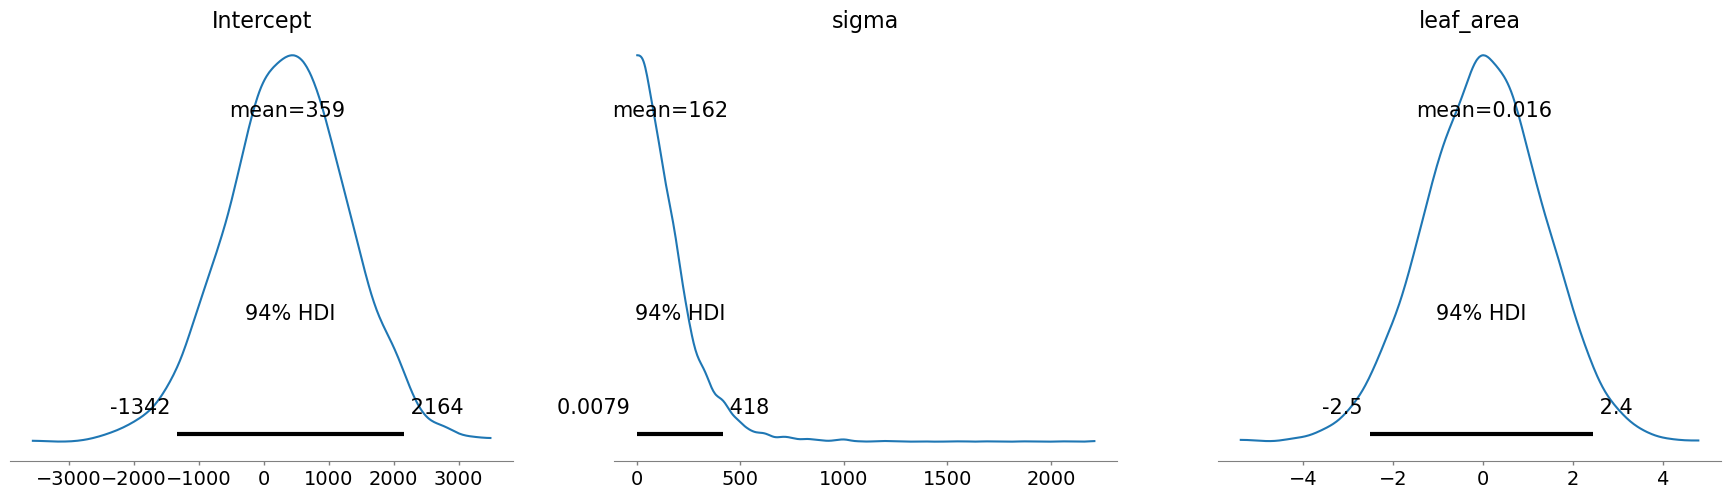

In [6]:
model.plot_priors()
plt.show()

## Sampling the Prior

Before the model starts fitting, we see that `bambi` has chosen sensible priors for us, they are "weakly informative" but the ranges are not totally insane when we look at the final model parameters. We can actually sample from these priors and use the samples to build some possible regression lines! (Don't worry about the code). We will sample the prior and plot some lines using the slopes (`leaf_area` - this is our $\beta$) and `Intercept` values.

In [7]:
# 100 points inside the range of our data
X = np.linspace(0, mss.leaf_area.max(), 100)

In [8]:
# Sample

prior_idata = model.prior_predictive()
# The samples are in 4 sublists (one for each chain), mush them into one long column
intercepts = np.array(prior_idata.prior["Intercept"]).reshape(-1, 1)
slopes = np.array(prior_idata.prior["leaf_area"]).reshape(-1, 1)
sigmas = np.array(prior_idata.prior["sigma"]).reshape(-1, 1)

# adding and multiplying *as vectors*
lines = intercepts + X * slopes
lines.shape

Sampling: [Intercept, leaf_area, sigma, text_area]


(500, 100)

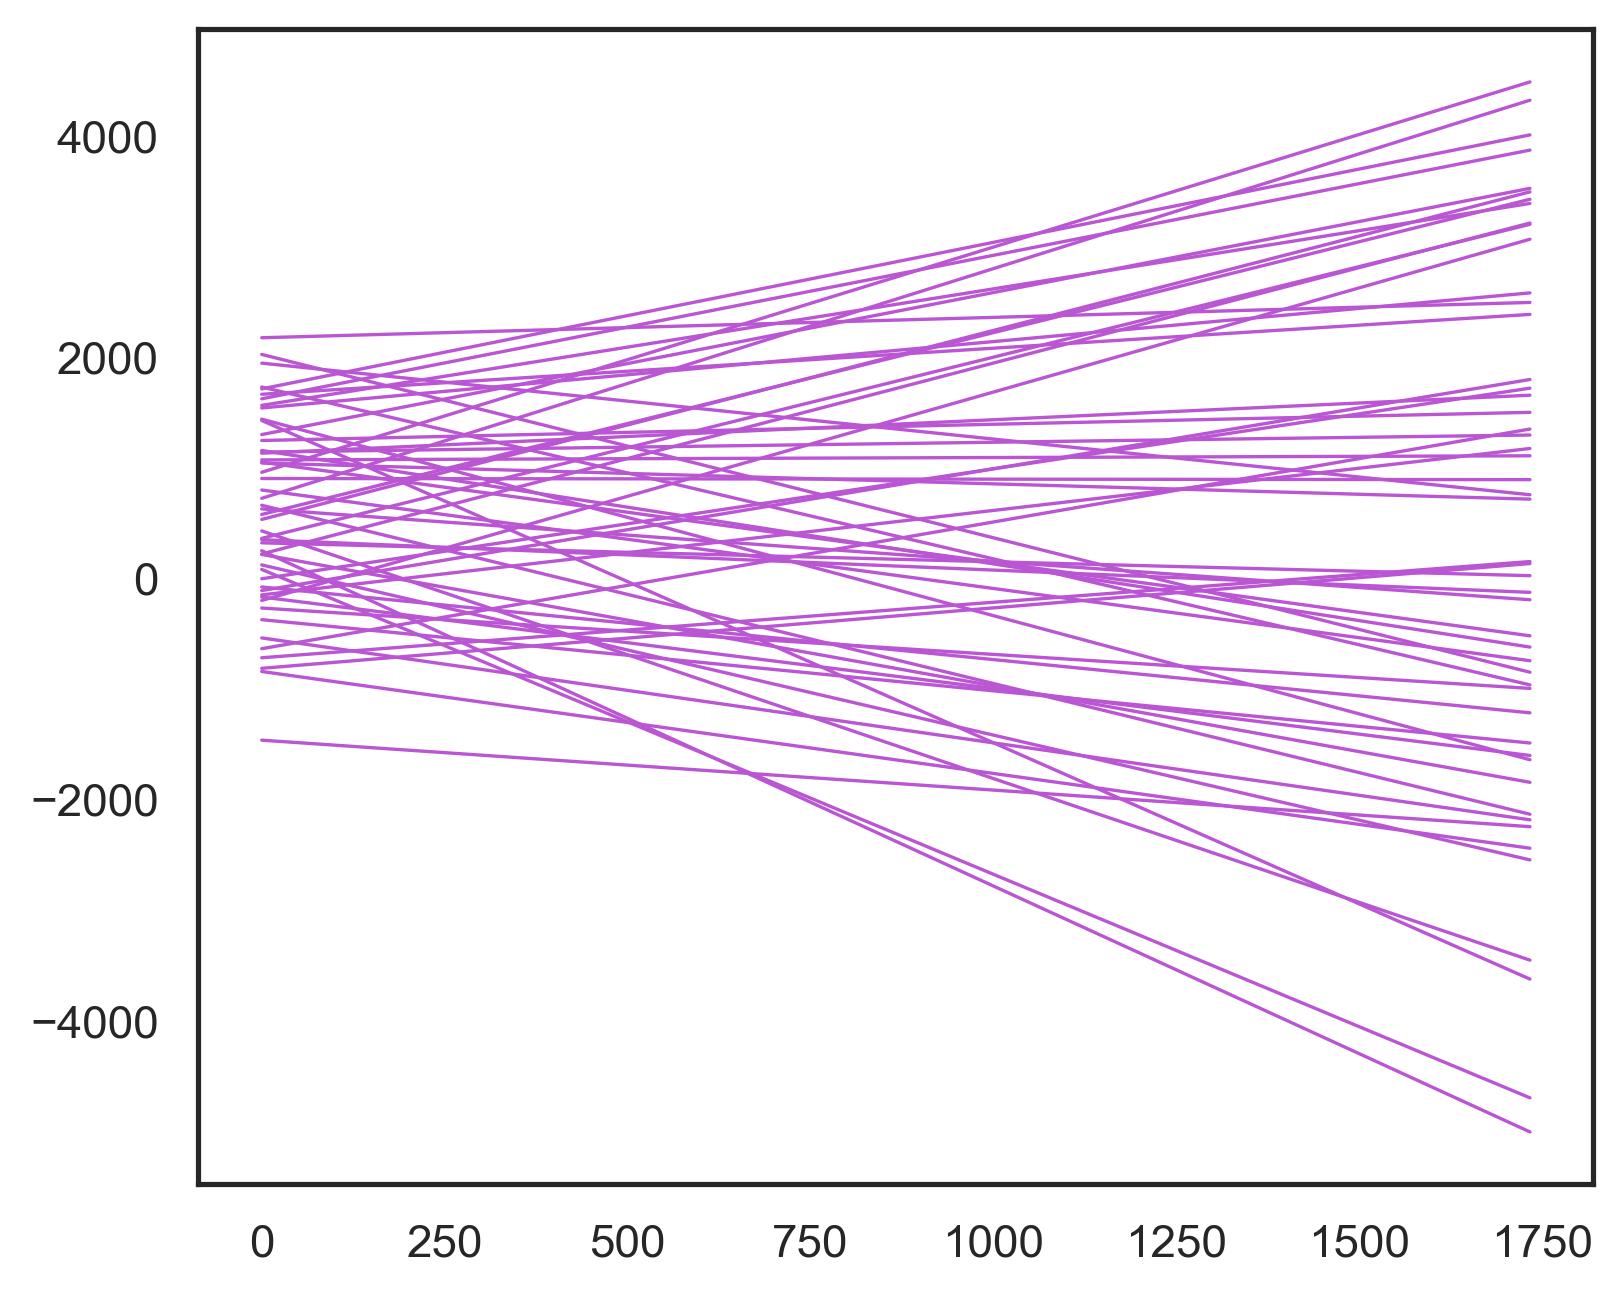

In [9]:
# Plot

sns.set_theme(rc={"figure.figsize": (6, 5), "figure.dpi": 300}, style="white")
lines_samp = rng.choice(lines, 50, replace=False)
for y in lines_samp:
    sns.lineplot(x=X, y=y, color="mediumorchid", linewidth=0.8)

plt.show()
sns.reset_defaults()

So, we see that our priors allow positive and negative slopes (but not **too** extreme) and a wide range of `Intercept` values.

## Inference!

A mathematical description of Bayesian statistics is outside the scope of this course, but the key thing to understand, is that **there is no minimum sample size for Bayesian inference**. Every data point will be used to *update* the prior distribution. That updated distribution is called the posterior. As we make more observations, we *update our prior* each time, and the estimations get tighter and tighter.

Now it's time to look at how that happens. This plot shows the fitting process. We used four "chains" to do "sampling" and we see that the model "converged" on the posterior estimates on the left. Notice how the chains (4 colors) all agree, more or less, on the mean estimate, and that the estimate distributions are *much tighter* than the priors. This is because every data point lets the model guess a distribution that is more consistent, while still being aware of **how much uncertainty** there is (the spread of the posterior distributions). Also notice that the posterior estimates are **not** theoretical normals, they are much wigglier! This is because they don't come from a PDF based on estimated parameters, they come right from the data!

For example, our `Intercept` prior had a credible interval between -1400 and 2100, but after considering all of the observations, the credible spread is from about 30 to 70.

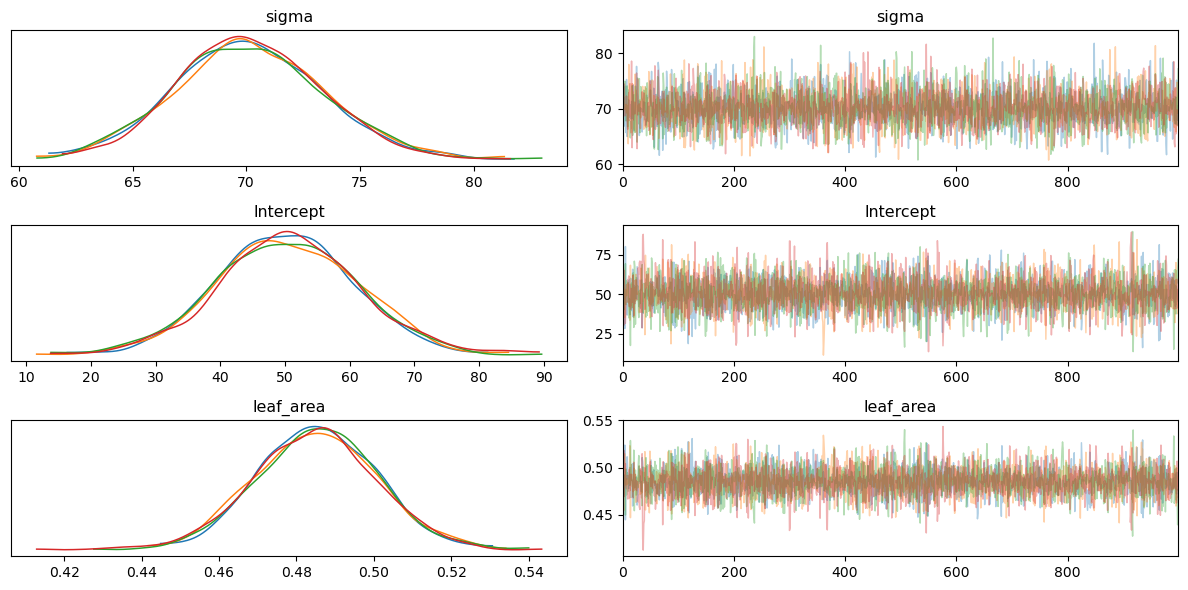

In [10]:
az.plot_trace(idata, compact=False)
plt.tight_layout()
plt.show()

Let's look at some modeled regression lines again, this time sampling from the **posterior** distributions (after considering the observations):

In [11]:
intercepts = np.array(idata.posterior["Intercept"]).reshape(-1, 1)
slopes = np.array(idata.posterior["leaf_area"]).reshape(-1, 1)
sigmas = np.array(idata.posterior["sigma"]).reshape(-1, 1)
lines = intercepts + X * slopes

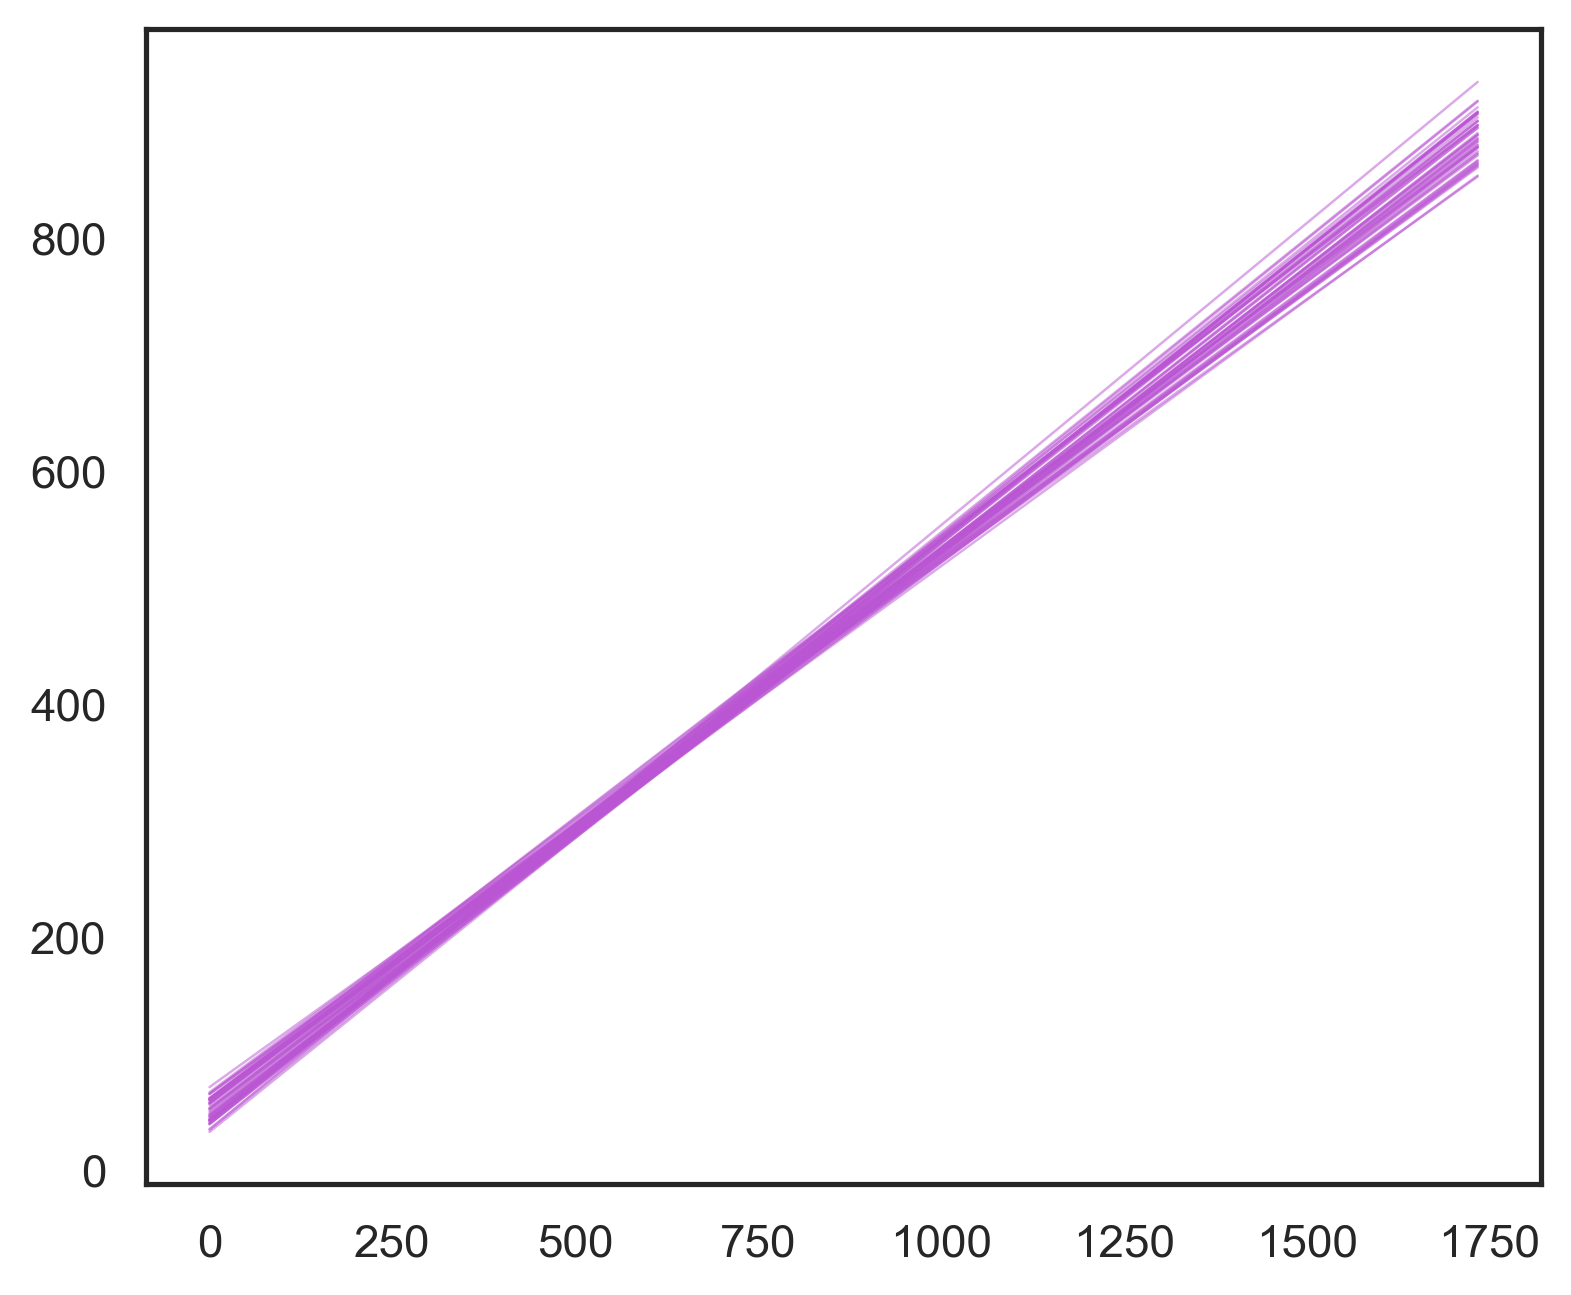

In [12]:
sns.set_theme(rc={"figure.figsize": (6, 5), "figure.dpi": 300}, style="white")
lines_samp = rng.choice(lines, 50, replace=False)
for y in lines_samp:
    sns.lineplot(x=X, y=y, color="mediumorchid", linewidth=0.6, alpha=0.5)
plt.show()
sns.reset_defaults()

... and let's add back our observations!

Notice how the sampled regression lines are still all different, but they are much more consistent. We don't know which one of these lines is the "true mean" of the distribution, but we can be pretty sure that it lies *somewhere* in the purple area.

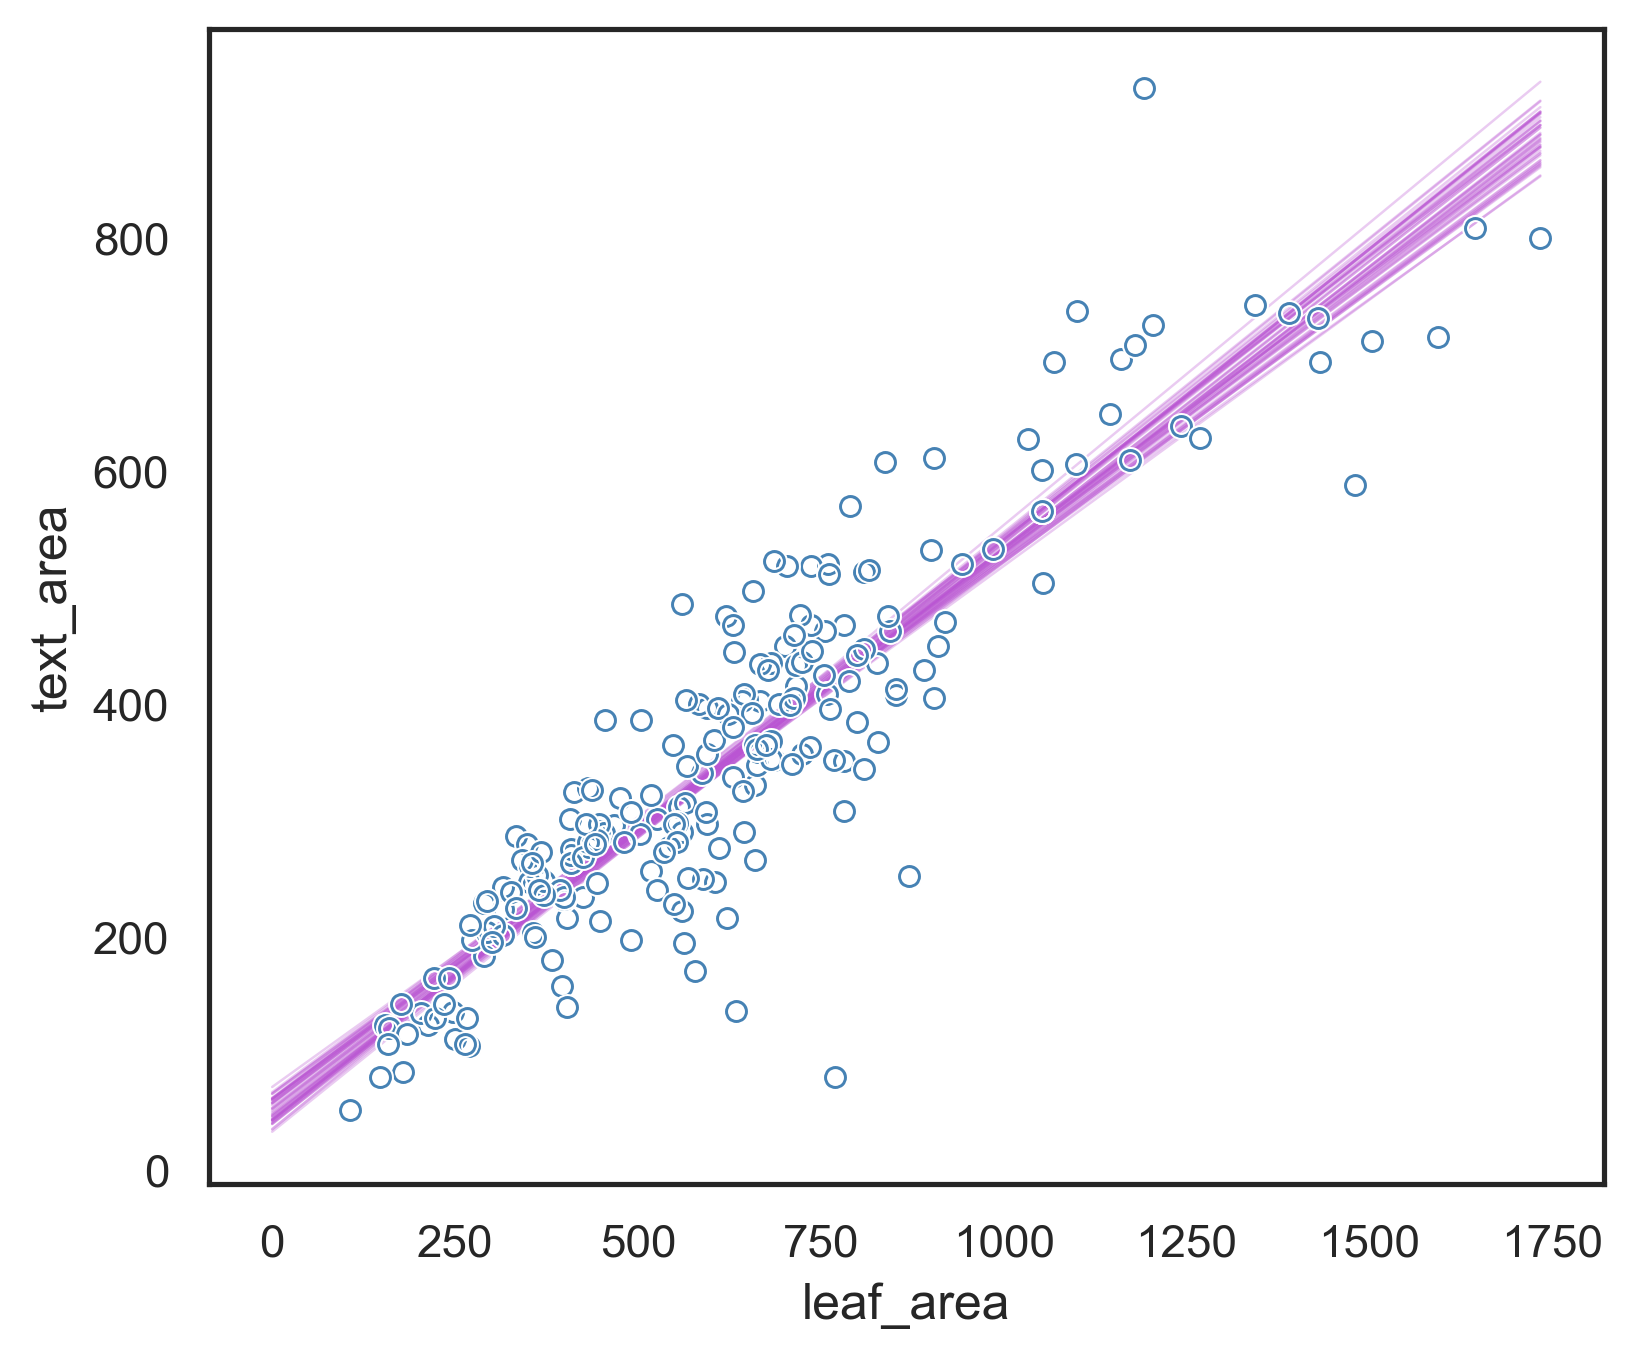

In [13]:
sns.set_theme(rc={"figure.figsize": (6, 5), "figure.dpi": 300}, style="white")
for y in lines_samp:
    sns.lineplot(x=X, y=y, color="mediumorchid", linewidth=0.6, alpha=0.3)
sns.scatterplot(
    x=mss.leaf_area, y=mss.text_area, color="steelblue", marker=r"$\circ$", zorder=2
)
plt.show()
sns.reset_defaults()

Here's how the fit changes as we gradually add points. To make the gif, at each step we fitted a new model on partial data, and then took 50 samples from the posterior predictive distribution of means ('bayesian lines'). You can see that the general nature of the relationship is totally unclear at first, but the model gradually tightens its estimates...

![scatter](./scatter.gif)

But remember:

#### What we are really modelling here is NOT A LINE, it is a DISTRIBUTION OF POSTERIOR PREDICTIONS. The line is just the *mean* value for the normal distribution that drives the predictions:

$\Large \hat{Y} \sim \mathcal{N}(\mu, \sigma^2)$

where

$\Large \mu =\beta_0 + x\beta_1$





## Sampling the Posterior

To see this, we will finish by sampling a lot of points from the "posterior predictive distribution". You won't be asked to replicate this code, just try to think about what we are doing:
- For our sample x-axis values...
- multiply by a random slope from the posterior distribution of slopes
- add a random intercept from the posterior distribution of intercepts - this is the predicted *mean*
- **PREDICT** a Y value for that x-value using a normal distribution, with a variance from the posterior distribution of sigmas

In [14]:
# We'll predict for the entire posterior, and subsample below

# reshape X to be a row (maths reasons) so we can 'broadcast' by the slopes column. This gives us a
# 2d array with 100 x-axis values, each multiplied by the corresponding slope. This is 'mx' in line
# terms.
points_y = X.reshape(1, -1) * slopes
# Add the intercept column across every row, this is the '+ c'
points_y += intercepts
# Now map every individual point to one sample from a normal distribution where mu is the 'line
# value' (mean estimate). This adds the variation around the mean.
points_y = rng.normal(points_y, sigmas)

In [15]:
# 20 samples per X value.
points_samp = rng.choice(points_y, 20, replace=False).ravel()

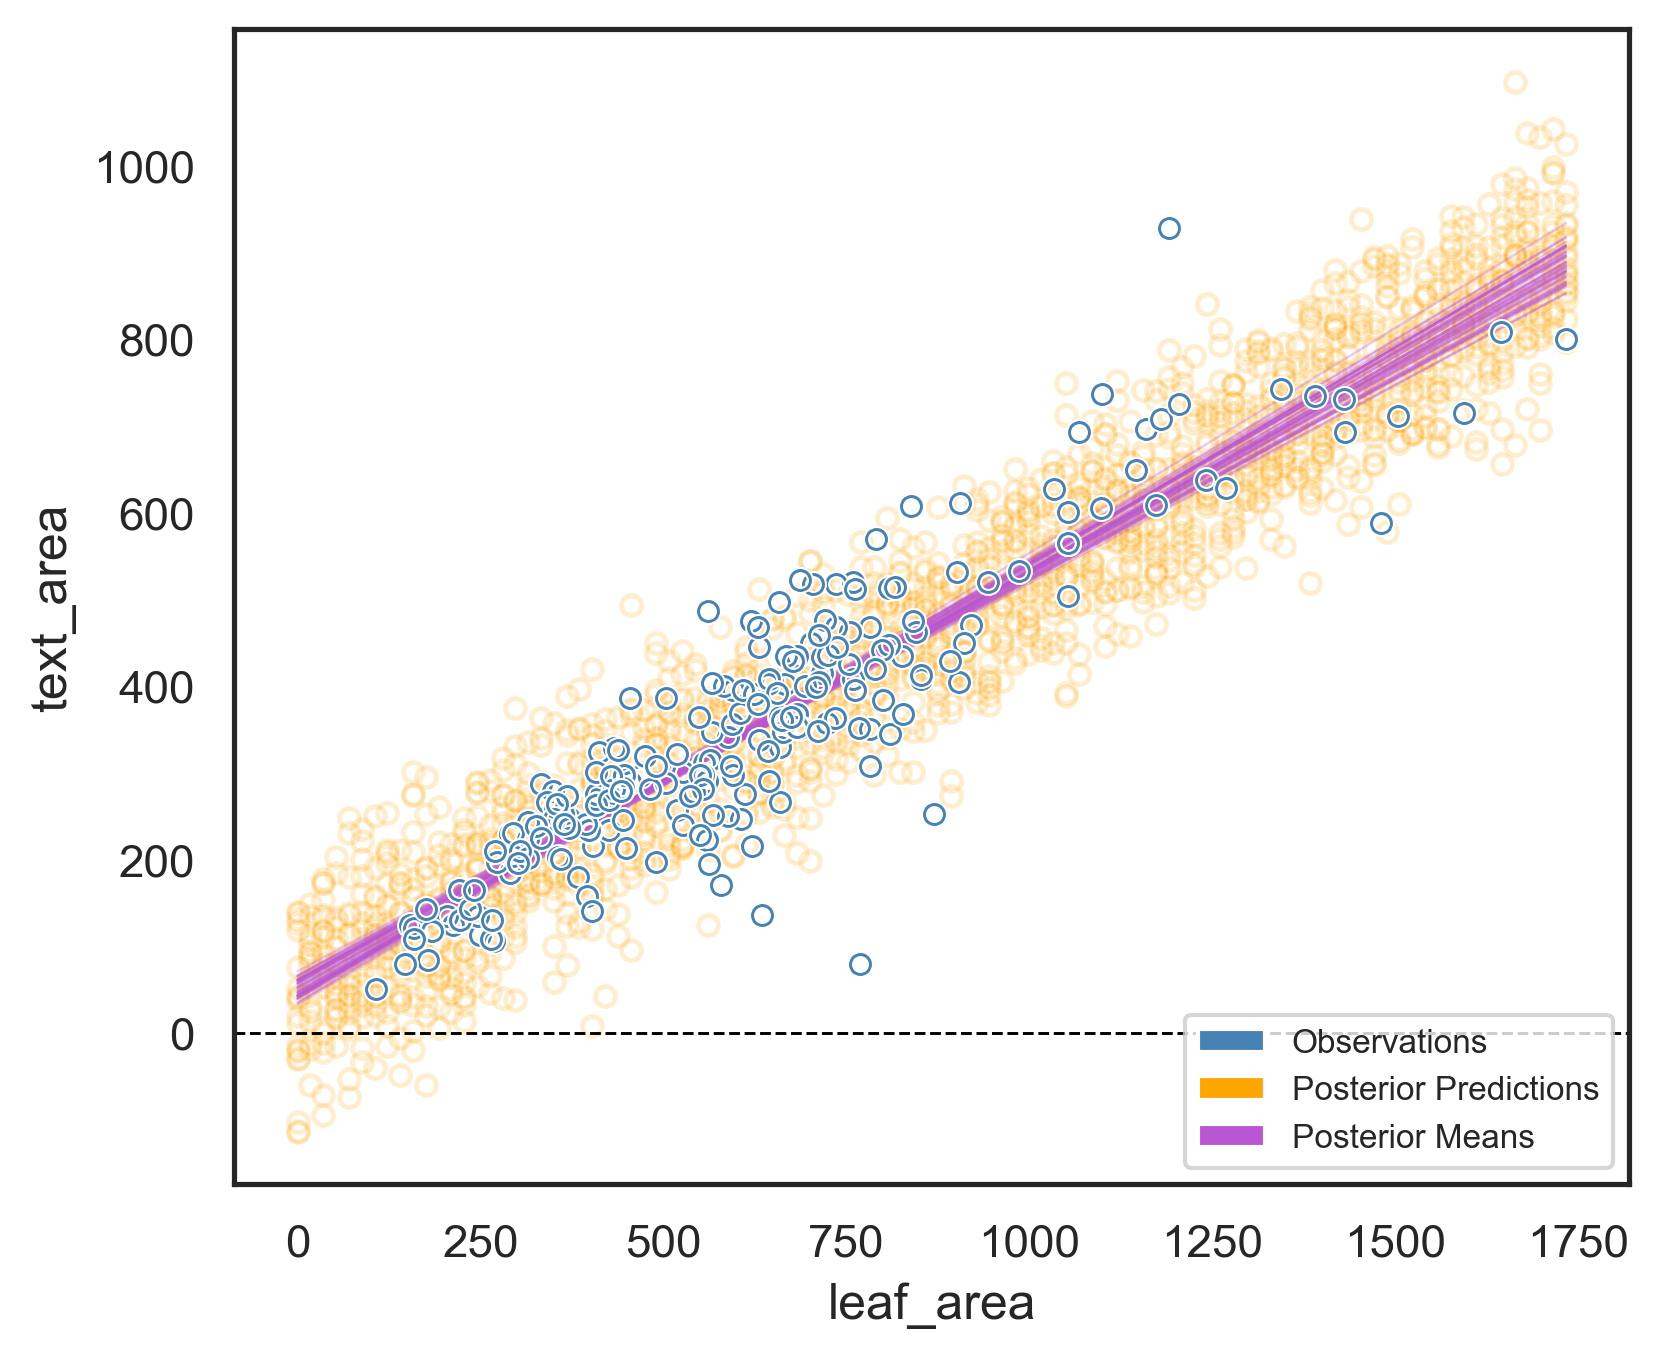

In [16]:
sns.set_theme(rc={"figure.figsize": (6, 5), "figure.dpi": 300}, style="white")

# draw posterior mean lines
for y in lines_samp:
    sns.lineplot(x=X, y=y, color="mediumorchid", linewidth=0.6, alpha=0.3, zorder=2)

# draw posterior (point) predictions
ax = sns.scatterplot(
    x=np.tile(X, 20),
    y=points_samp,
    color="orange",
    marker=r"$\circ$",
    alpha=0.2,
    zorder=1,
)

# draw observations
sns.scatterplot(
    x=mss.leaf_area, y=mss.text_area, color="steelblue", marker=r"$\circ$", zorder=3
)

# add legend
handles = [
    Patch(label="Observations", facecolor="steelblue"),
    Patch(label="Posterior Predictions", facecolor="orange"),
    Patch(label="Posterior Means", facecolor="mediumorchid"),
]
ax.axhline(0, linestyle="--", color="black", linewidth=0.7)
legend = ax.legend(handles=handles, loc=4, fontsize=8, frameon=True, framealpha=0.8)
plt.show()
sns.reset_defaults()

## That was a lot.

If you are anything like us, this will have been a lot to take in at first. For now, just remember two things:
1. In Bayesian modelling, the **uncertainty is a visible part of the model**
2. **The minimum sample size for Bayesian analysis is ONE.** (you will just get very uncertain estimates)

![image.png](./halfbaked.jpeg)

```
Version History

Current: v1.0.0

14/10/24: 1.0.0: first draft, BN
```

### Software versions used

These notebooks can be a bit tricky to get to work across all platforms and configurations. For the record, here are the versions they were run with on my machine.

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Nov 24 2024

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.28.0

numpy     : 1.26.4
matplotlib: 3.9.2
xarray    : 2024.10.0
arviz     : 0.17.1
bambi     : 0.14.0
pandas    : 2.2.2
seaborn   : 0.13.2
logging   : 0.5.1.2

Watermark: 2.5.0

